In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib as ta
import optuna
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

/home/kanai/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
csv_use_cols = ["Date", "Open", "High", "Low", "Close", "Volume"]
shift = 20

In [3]:
df = pd.read_csv("btcjpy_data_from_yfinance-5y-1d.csv",usecols=csv_use_cols)

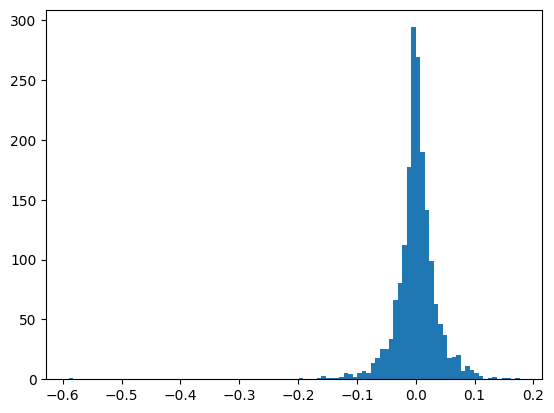

In [4]:
def multilabel_func(x):
    param2 = 0.05
    param1 = 0.02
    param0 = 0.008
    param = 0.002
    if x > param2: return 4
    elif param2 >= x > param1: return 3
    elif param1 >= x > param0: return 2
    elif param0 >= x > param: return 1
    elif param >= x > -1*param: return 0
    elif -1*param >= x > -1*param0: return -1
    elif -1*param0 >= x > -1*param1: return -2
    elif -1*param1 >= x > -1*param2: return -3
    elif x < -1*param2: return -4

df["diff_ratio"] = df["Close"].diff()/df["Close"] 
plt.hist(df["diff_ratio"],bins=100)
plt.show()

droped: 3


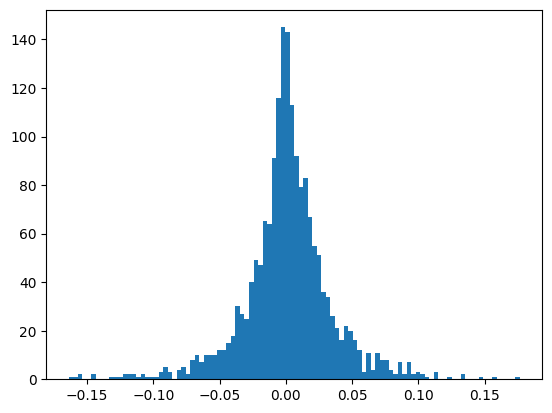

In [5]:
before_index = df.shape[0]
df = df[df["diff_ratio"]>-0.18]
print("droped:",before_index-df.shape[0])
plt.hist(df["diff_ratio"],bins=100)
plt.show()

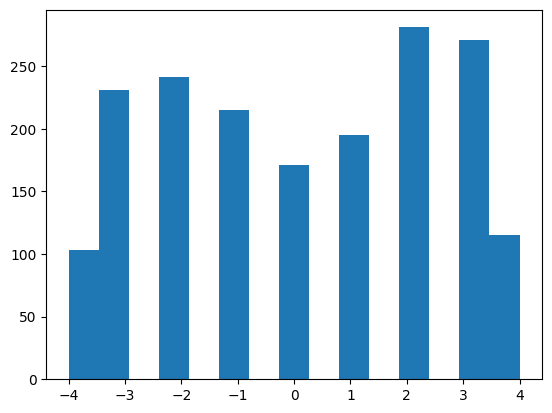

In [6]:
df["target"] = np.vectorize(multilabel_func)(df["diff_ratio"])
df["target"] = df["target"].shift(-1)

plt.hist(df["target"],bins=15)
plt.show()

In [7]:
df["EMA5"] = ta.EMA(df["Close"], timeperiod=5)
df["EMA25"] = ta.EMA(df["Close"], timeperiod=25)
df["EMA50"] = ta.EMA(df["Close"], timeperiod=50)
df["EMA100"] = ta.EMA(df["Close"], timeperiod=100)
df["RSI"] = ta.RSI(df["Close"], timeperiod=14)
df["MFI"] = ta.MFI(df["High"], df["Low"], df["Close"], df["Volume"], timeperiod=14)

for i in range(0, shift+1):
    df["Open-{0}ratio".format(i)] = df["Open"].shift(i)/df["Close"]
    df["High-{0}ratio".format(i)] = df["High"].shift(i)/df["Close"]
    df["Low-{0}ratio".format(i)] = df["Low"].shift(i)/df["Close"]
    df["Close-{0}ratio".format(i)] = df["Close"].shift(i)/df["Close"]
    df["EMA5-{0}ratio".format(i)] = df["EMA5"].shift(i)/df["Close"]
    df["EMA25-{0}ratio".format(i)] = df["EMA25"].shift(i)/df["Close"]
    df["EMA50-{0}ratio".format(i)] = df["EMA50"].shift(i)/df["Close"]
    df["EMA100-{0}ratio".format(i)] = df["EMA100"].shift(i)/df["Close"]
    df["Volume-{0}".format(i)] = df["Volume"].shift(i)
    df["RSI-{0}".format(i)] = df["RSI"].shift(i)
    df["MFI-{0}".format(i)] = df["MFI"].shift(i)

df.dropna(axis=0,inplace=True)
df.reset_index(drop=True, inplace=True)

/tmp/ipykernel_7106/308158195.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["High-{0}ratio".format(i)] = df["High"].shift(i)/df["Close"]
/tmp/ipykernel_7106/308158195.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["Low-{0}ratio".format(i)] = df["Low"].shift(i)/df["Close"]
/tmp/ipykernel_7106/308158195.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=

In [8]:
mlcols = []
for i in range(0, shift+1):
    mlcols.append("Open-{0}ratio".format(i))
    mlcols.append("High-{0}ratio".format(i))
    mlcols.append("Low-{0}ratio".format(i))
    mlcols.append("Close-{0}ratio".format(i))
    mlcols.append("EMA5-{0}ratio".format(i))
    mlcols.append("EMA25-{0}ratio".format(i))
    mlcols.append("EMA50-{0}ratio".format(i))
    mlcols.append("EMA100-{0}ratio".format(i))
    mlcols.append("Volume-{0}".format(i))
    mlcols.append("RSI-{0}".format(i))
    mlcols.append("MFI-{0}".format(i))

X = df[mlcols]
Y = df["target"]
print(X.describe())
print(X.info)
print(Y.describe())
print(Y.info)
xgbtraindata = xgb.DMatrix(data=X, label=Y)

       Open-0ratio  High-0ratio   Low-0ratio  Close-0ratio  EMA5-0ratio  \
count  1704.000000  1704.000000  1704.000000        1704.0  1704.000000   
mean      0.998906     1.020419     0.976526           1.0     0.998494   
std       0.034137     0.023868     0.024736           0.0     0.032605   
min       0.824706     0.991138     0.718463           1.0     0.881475   
25%       0.982955     1.005254     0.968634           1.0     0.981810   
50%       0.999276     1.011707     0.984200           1.0     0.997791   
75%       1.013734     1.026462     0.992829           1.0     1.012502   
max       1.163937     1.190510     1.010575           1.0     1.279500   

       EMA25-0ratio  EMA50-0ratio  EMA100-0ratio      Volume-0        RSI-0  \
count   1704.000000   1704.000000    1704.000000  1.704000e+03  1704.000000   
mean       0.991298      0.983328       0.968928  3.546974e+12    53.277035   
std        0.090718      0.131850       0.183070  1.972779e+12    14.011616   
min     

In [9]:
def objective(trial,df_X,df_y):
    params ={
        'max_depth':trial.suggest_int("max_depth",3,12),
        'min_child_weight':trial.suggest_int('min_child_weight',1,5),
        'gamma':trial.suggest_float('gamma',0,1),
        'subsample':trial.suggest_float('subsample',0,1),
        'colsample_bytree':trial.suggest_float('colsample_bytree',0,1),
        'reg_alpha':trial.suggest_float('reg_alpha',1e-5,100,log=True),
        'reg_lambda':trial.suggest_float('reg_lambda',1e-5,100,log=True),        
        'learning_rate':trial.suggest_float('learning_rate',0,0.7)}
    
    model = xgb.XGBRegressor(**params)
    scores = cross_val_score(model, df_X, df_y, scoring='neg_mean_squared_error', cv=5)
    score_mean = -1*np.mean(scores)
    
    return score_mean

study = optuna.create_study()
study.optimize(lambda trial: objective(trial,X,Y), n_trials=10)

print(study.best_params)

[I 2024-01-29 17:42:21,521] A new study created in memory with name: no-name-8f5dba81-89e3-4ba6-aefe-cdb582a6681a
[I 2024-01-29 17:42:24,095] Trial 0 finished with value: 6.154536771687715 and parameters: {'max_depth': 4, 'min_child_weight': 3, 'gamma': 0.16041874477329088, 'subsample': 0.9508535255845519, 'colsample_bytree': 0.7092811147710553, 'reg_alpha': 2.4996572885042063, 'reg_lambda': 0.005175611298863513, 'learning_rate': 0.07642776396005771}. Best is trial 0 with value: 6.154536771687715.
[I 2024-01-29 17:42:28,060] Trial 1 finished with value: 16.832078867760146 and parameters: {'max_depth': 9, 'min_child_weight': 3, 'gamma': 0.4449726504989562, 'subsample': 0.4243549606837145, 'colsample_bytree': 0.4855397346622903, 'reg_alpha': 0.0003731426353932951, 'reg_lambda': 0.000123120657898902, 'learning_rate': 0.5257594217302128}. Best is trial 0 with value: 6.154536771687715.
[I 2024-01-29 17:42:32,914] Trial 2 finished with value: 7.420465264894988 and parameters: {'max_depth': 7

{'max_depth': 9, 'min_child_weight': 4, 'gamma': 0.5041857465918176, 'subsample': 0.8700992357479028, 'colsample_bytree': 0.1270784046667296, 'reg_alpha': 0.00040457193233085716, 'reg_lambda': 0.003071662947102456, 'learning_rate': 0.03137727914388603}


In [12]:
params = study.best_params
dd = xgb.cv(params, xgbtraindata, num_boost_round=10000, early_stopping_rounds=10, nfold=4, metrics='rmse', seed=0)
plt.plot(dd)
plt.legend(dd.columns)
plt.savefig("cv.png")
plt.show()

MSE
4.452729204789912


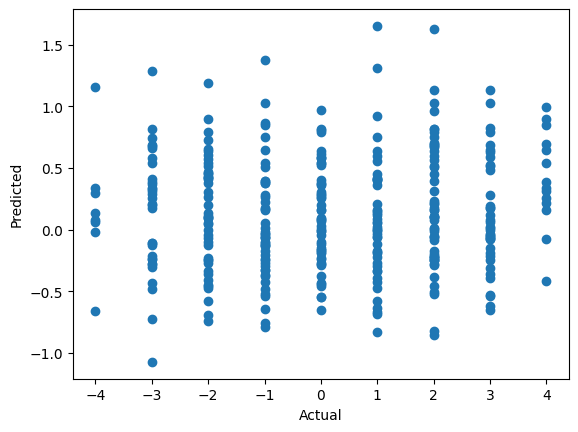

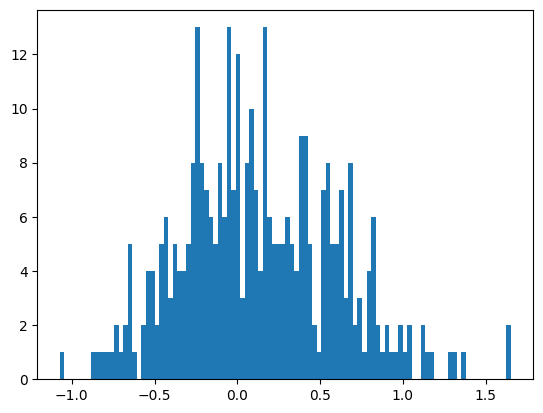

<Figure size 5000x5000 with 0 Axes>

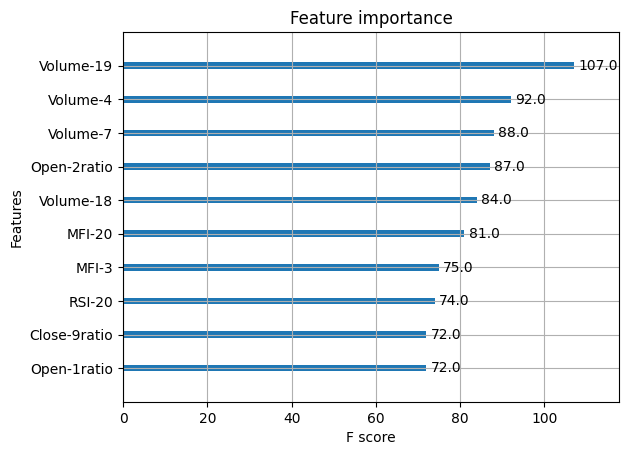

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)
model = XGBRegressor(objective='reg:squarederror', **params)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print("MSE")
print(mean_squared_error(Y_test, Y_pred))
plt.scatter(Y_test, Y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.savefig("prediction.png")
plt.show()

plt.hist(Y_pred, bins=100)
plt.show()

fig = plt.figure(figsize=(100,100),dpi=50)
plot_importance(model, max_num_features=10)
plt.savefig("feature_importance.png")
plt.rcParams["figure.figsize"] = [100,100]
plt.show()